# Weight Minimization Weights Study

The goal of this nb is to study the overfitting / overparametrization due to the number of weights/replicas included in the PDF parametrization

Could the very wiggly loss values as a function of the epoch be explained by overparametrization?

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import optax
from flax.training.early_stopping import EarlyStopping

import jax
import jax.numpy as jnp

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys.loader import Loader
from validphys import convolution
from validphys.convolution import evolution

from super_net.data_batch import DataBatch
from super_net.core import NewDataGroupSpec
from super_net.mc_wmin.mc_wmin_core import MCDataGroupSpec
from super_net.mc_wmin.sum_rules_wmin import sum_rules_constraint


## Metadata and Data

In [2]:
# {'dataset': 'NMCPD_dw_ite'}, 
DIS_datasets = [{'dataset': 'SLACP_dwsh'},
                      {'dataset': 'SLACD_dw_ite'}, {'dataset': 'BCDMSP_dwsh'},
                      {'dataset': 'BCDMSD_dw_ite'}, {'dataset': 'CHORUSNUPb_dw_ite'},
               {'dataset': 'CHORUSNBPb_dw_ite'}, {'dataset': 'NTVNUDMNFe_dw_ite', 'cfac': ['MAS']},
               {'dataset': 'HERACOMBNCEM'}, {'dataset': 'HERACOMBNCEP575'}, 
               {'dataset': 'HERACOMBNCEP820'}, {'dataset': 'HERACOMBNCEP920'}, 
               {'dataset': 'HERACOMBCCEP'}, {'dataset': 'HERACOMB_SIGMARED_C'},
               {'dataset': 'HERACOMBCCEM'}, {'dataset': 'HERACOMBNCEP460'}, {'dataset':'HERACOMB_SIGMARED_B'},
               {'dataset':'HERACOMB_SIGMARED_B'}, {'dataset':'NMC'}, 
               {'dataset': 'NTVNBDMNFe_dw_ite', 'cfac': ['MAS']}]


inp = {
    "fit": "210713-n3fit-001",
    "dataset_inputs": DIS_datasets,
    "use_cuts": "internal",
    "theoryid": 400
}

In [3]:
data = API.data(**inp)

In [4]:
new_data = MCDataGroupSpec(name = "data", datasets = data.datasets, dsinputs = data.dsinputs)


Ndat = sum([cd.ndata for cd in new_data.load_commondata_instance()])

def len_training_set(Ndat, test_size, random_state):
    idx_train, idx_test = train_test_split(jnp.arange(Ndat), test_size=test_size, random_state=random_state)
    return len(idx_train), len(idx_test)

test_size=0.2
random_state=10
N_train, N_test = len_training_set(Ndat, test_size, random_state)

2023-06-16 16:36:09.773101: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-06-16 16:36:09.833062: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


In [9]:
# Random Initial Weights
l = Loader()
pdf = l.check_pdf("210713-n3fit-001")

# shape (101, 14, 50)
# LinearBasis Class - > implements basis transformation from flavour to any?
# grid_values: Evaluate ``x*f(x)`` on a grid of points in flavour, x and Q.

xgrid = load_fktable(data.datasets[0].fkspecs[0]).xgrid

INPUT_GRID = evolution.grid_values(pdf, convolution.FK_FLAVOURS, xgrid, [1.65]).squeeze(-1)

INPUT_GRID.shape

(101, 14, 50)

In [10]:
nweights=100
# Randomly select "n" indices from the first dimension
selected_indices = np.random.choice(INPUT_GRID.shape[0], size=nweights, replace=False)

# Create the subset array based on the selected indices
INPUT_GRID = INPUT_GRID[selected_indices]

print(INPUT_GRID.shape)

rng = jax.random.PRNGKey(0xDEADBEEF)
# initial weights for weight minimization
weight_base_num = jax.random.normal(rng, shape=(INPUT_GRID.shape[0],))
weight_base = weight_base_num/jnp.sum(weight_base_num)


chi2_contribs_data_mini_batch = new_data.make_chi2_data_mini_batch(train_val_split=True, test_size=test_size, random_state=random_state)

chi2_validation = new_data.make_chi2_validation(test_size=test_size, random_state=random_state)

(100, 14, 50)


In [11]:
@jax.jit
def loss_data_batch(weights,batch_idx, LAMBDA):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    sum_rules_violation = sum_rules_constraint(weights)
    return chi2_contribs_data_mini_batch(pdf,batch_idx, sum_rules_violation, LAMBDA)

@jax.jit
def loss_validation(weights, LAMBDA):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    # enforce sum rules
    sum_rules_violation = sum_rules_constraint(weights)
    return chi2_validation(pdf, sum_rules_violation, LAMBDA)

# @jax.jit
# def update_weights(step,opt_state,batch_idx):
#     params  = get_params(opt_state)
#     return opt_update(step, jax.grad(loss_data_batch)(params,batch_idx),opt_state)

def fit(nr_epochs: int, num_batches, batches, batch_size, LAMBDA, params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
    """"""
    params_list = []
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params,opt_state,batch_idx):
        loss_value, grads = jax.value_and_grad(loss_data_batch)(params,batch_idx, LAMBDA)
        updates, opt_state = optimizer.update(grads,opt_state,params)
        params = optax.apply_updates(params,updates)
        
        # compute validation and training loss on the same weights
        loss_valid = loss_validation(params, LAMBDA)
        loss = loss_data_batch(params,batch_idx, LAMBDA)
        
        return params, opt_state, loss, loss_valid
    
    loss = []
    val_loss = []
    
    early_stop = EarlyStopping(min_delta=1e-7, patience=300)
    
    for i in range(nr_epochs):
        
        epoch_loss = 0
        epoch_val_loss = 0
        
        for _ in range(num_batches):
            batch = next(batches)
            params, opt_state, loss_value, loss_valid = step(params, opt_state, batch)
            
            epoch_loss+=loss_value / batch_size
            
            epoch_val_loss+=loss_valid / N_test
            
        epoch_loss /= num_batches
        epoch_val_loss /= num_batches
        
        loss.append(epoch_loss)
        val_loss.append(epoch_val_loss)        
        
        params_list.append(params)
        
        if i % 10 == 0:        
        
            _, early_stop = early_stop.update(epoch_val_loss)
            

            if early_stop.should_stop:
                print('Met early stopping criteria, breaking...')
                break
                
        if i%100==0:
            print(f'step {i}, loss: {epoch_loss:.3f}, validation_loss: {epoch_val_loss:.3f}')        
            _, early_stop = early_stop.update(epoch_val_loss)
            print(f"epoch:{i}, early_stop: {early_stop}")
    
    # return the parameters for which the validation loss is the best
#     params_list = jnp.array(params_list)
#     val_loss = jnp.array(val_loss)
#     opt_param = params_list[jnp.argmin(val_loss)]
    
    return params, loss, val_loss


In [52]:
batch_size = 128


databatch = DataBatch(Ndat=N_train,batch_size=batch_size,seed=1)
batches = databatch.data_batch_stream_index()
num_batches = databatch.num_batches()

initial_params = weight_base
nr_epochs = 4000


    
optimizer = optax.adam(learning_rate=5e-4)
params, loss, val_loss = fit(nr_epochs, num_batches, batches, batch_size, 0, initial_params, optimizer)


step 0, loss: 1.270, validation_loss: 1.244
epoch:0, early_stop: EarlyStopping(min_delta=1e-07, patience=300, best_metric=Array(1.2441622, dtype=float32), patience_count=1, should_stop=False)
step 100, loss: 1.200, validation_loss: 1.225
epoch:100, early_stop: EarlyStopping(min_delta=1e-07, patience=300, best_metric=Array(1.2252119, dtype=float32), patience_count=1, should_stop=False)
step 200, loss: 1.222, validation_loss: 1.228
epoch:200, early_stop: EarlyStopping(min_delta=1e-07, patience=300, best_metric=Array(1.2240784, dtype=float32), patience_count=2, should_stop=False)
step 300, loss: 1.180, validation_loss: 1.221
epoch:300, early_stop: EarlyStopping(min_delta=1e-07, patience=300, best_metric=Array(1.2211297, dtype=float32), patience_count=4, should_stop=False)
step 400, loss: 1.160, validation_loss: 1.224
epoch:400, early_stop: EarlyStopping(min_delta=1e-07, patience=300, best_metric=Array(1.218658, dtype=float32), patience_count=3, should_stop=False)
step 500, loss: 1.170, va

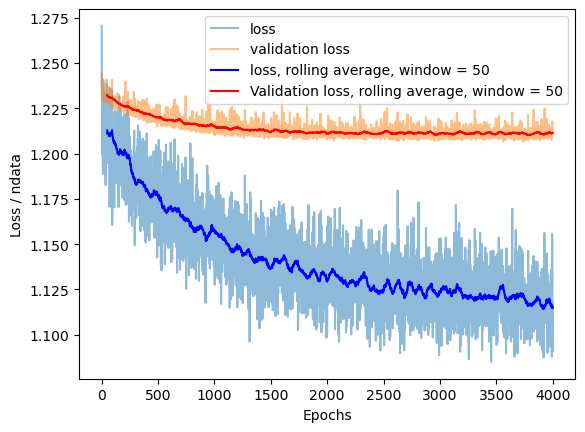

In [53]:
import matplotlib.pyplot as plt
import pandas as pd



loss = np.array(loss)
val_loss = np.array(val_loss)

df = pd.DataFrame({"loss":loss})
df_val = pd.DataFrame({"val_loss":val_loss})

fig, ax = plt.subplots()

ax.plot(loss, label = "loss", alpha=0.5)
ax.plot(val_loss, label="validation loss", alpha=0.5)

wind_size = 50

ax.plot(df.rolling(wind_size).mean().to_numpy(), 'b', label = f"loss, rolling average, window = {wind_size}")
ax.plot(df_val.rolling(wind_size).mean().to_numpy(),'r', label = f"Validation loss, rolling average, window = {wind_size}")

# ax.set_title(f"Sum Rules = {jnp.sum(params):.3f}, LAMBDA = {LAMBDA}")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss / ndata")
ax.legend()

In [54]:
jnp.sum(params)

Array(1.0181187, dtype=float32)

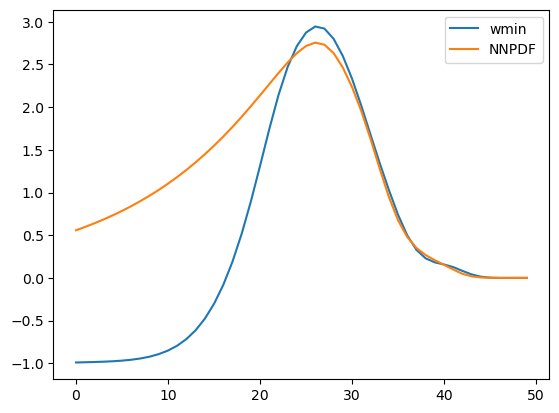

In [55]:
n=2
fig, ax = plt.subplots()
ax.plot(jnp.einsum("i,ijk->jk", params, INPUT_GRID)[n, :], label = 'wmin')

ax.plot(INPUT_GRID[0, n,:], label='NNPDF')
ax.legend()